In [24]:
from os import listdir
import random

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load all docs in a directory
def process_docs(directory):
    # walk through all files in the folder
    full_dataset = []
    for filename in listdir(directory):
        # skip files that do not have the right extension
        if not filename.endswith(".txt"):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load document
        doc = load_doc(path)
        full_dataset.append(doc)
    return full_dataset

directory_neg = 'aclImdb/train/neg'
train = process_docs(directory_neg)
directory_pos = 'aclImdb/train/pos'
train.extend(process_docs(directory_pos))
train_target = [0] * 12500 + [1] * 12500

#shuffle training data
combined = list(zip(train, train_target))
random.shuffle(combined)
train[:], train_target[:] = zip(*combined)



In [27]:
# split training/validation data
train_split = 20000
train_data = train[:train_split]
train_targets = train_target[:train_split]

val_data = train[train_split:]
val_targets = train_target[train_split:]

# load test data
directory_neg = 'aclImdb/test/neg'
test_data = process_docs(directory_neg)
directory_pos = 'aclImdb/test/pos'
test_data.extend(process_docs(directory_pos))
test_targets = [0] * 12500 + [1] * 12500

print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [365]:
# Let's write the tokenization function 
import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]

# Try tokenize thoroughly
def tokenize_indetails(sent):
    tokens = tokenizer(sent)
    # lowercase and remove punctuation
    tokens = [token.text.lower() for token in tokens if (token.text not in punctuations)]
    # remove line break symbol
    tokens = [token for token in tokens if token != '/><br']
    for i in range(len(tokens)):
        if tokens[i].startswith('/>'):
            tokens[i] = tokens[i][2:]
        if tokens[i].endswith('<br'):
            tokens[i] = tokens[i][:-3]
        if tokens[i].endswith('.<br'):
            tokens[i] = tokens[i][:-4]
    tokens = tokenizer(' '.join(tokens))
    # get rid of stopword
    tokenizer.vocab["'s'"].is_stop = True
    tokenizer.vocab["'d'"].is_stop = True
    tokenizer.vocab["n't"].is_stop = True
    tokens = [token for token in tokens if not token.is_stop] 
    # remove character
    tokens = [str(token) for token in tokens if len(token) > 1] 
    return tokens
    
# Example
tokens = tokenize(u'Apple is looking at buying U.K. startup for $1 billion')
tokens2 = tokenize_indetails(u'Apple is looking at buying U.K. startup for $1 billion')
print (tokens)
print (tokens2)

['apple', 'is', 'looking', 'at', 'buying', 'u.k.', 'startup', 'for', '1', 'billion']
['apple', 'looking', 'buying', 'u.k', 'startup', 'billion']


In [357]:
import pickle as pkl

#create n-gram datasets
def tokenize_dataset(dataset, n_gram=1, tokenize_scheme='simple'):
    token_dataset = []
        # we are keeping track of all tokens in dataset 
        # in order to create vocabulary later
    all_tokens = []
    for sample in dataset:
        if tokenize_scheme == 'simple':
            tokens = tokenize(sample)
        if tokenize_scheme == 'detailed':
            tokens = tokenize_indetails(sample)
        n_tokens = []
        for i in range(len(tokens)-n_gram+1): 
            n_token = ' '.join(tokens[i:i+n_gram])
            n_tokens.append(n_token)
        token_dataset.append(n_tokens)
        all_tokens += n_tokens
    return token_dataset, all_tokens

In [112]:
from collections import Counter
def build_vocab(all_tokens, max_vocab_size = 10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    # save index 0 for unk and 1 for pad
    PAD_IDX = 0
    UNK_IDX = 1
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token


In [33]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [55]:
MAX_SENTENCE_LENGTH = 200
import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]


tensor([[   1, 1974,  292,  ...,    0,    0,    0],
        [  55,  736, 3223,  ...,   36,  640,  446],
        [   2, 1987,    9,  ...,    0,    0,    0],
        ...,
        [1888,  314,  152,  ...,    0,    0,    0],
        [  61,   46,   25,  ...,    0,    0,    0],
        [  10,  240,   25,  ...,   16,    1,   42]])
32 200
tensor([156, 200, 173, 116, 200, 200, 113, 117, 151, 200, 100,  77, 200, 132,
        200,  82, 107, 108, 142, 200, 200, 200, 143, 200, 200, 129,  33, 200,
        135,  70, 180, 200])
tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 1])


In [35]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out


In [431]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

# Function to train the model
def train_model(emb_dim = 100, vocab_size = len(id2token), learning_rate = 0.01, annealing_rate = 0, step = 10,
                num_epochs = 5, optim = 'Adam'):
    """
    Help function that tests the model's performance on a dataset
    @param: emb_dim - embedding size
            vocab_size - vocabulary size
            learning_rate - learning rate of the optimizer, if annealing_rate is not 0, this is a start learning
                rate
            annealing_rate - a factor that shrinks the learning rate every step size
            step - step size (epochs)
            optim - optimizer, can choose from 'Adam' or 'SGD'
            
    """
    model = BagOfWords(vocab_size, emb_dim)
    criterion = torch.nn.CrossEntropyLoss()  
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    # set the scheduler for learning rate
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=annealing_rate)
    epoch_train_loss = []
    epoch_val_acc = []
    for epoch in range(num_epochs):
        # only decay the learning rate when annealing rate is given
        if annealing_rate!=0:
            scheduler.step()
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
                
        epoch_train_loss.append(loss.item())
        val_acc = test_model(val_loader, model)
        print('Epoch: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, val_acc))
        epoch_val_acc.append(val_acc)
    return epoch_train_loss, epoch_val_acc

In [ ]:
plt.rcParams['figure.figsize'] = 10, 8

# Tokenization schemes

### run code below to tokenize simply

In [361]:
# # val set tokens
# print ("Tokenizing val data")
# val_data_tokens, _ = tokenize_dataset(val_data)
# pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# # test set tokens
# print ("Tokenizing test data")
# test_data_tokens, _ = tokenize_dataset(test_data)
# pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
# pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
# pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))
# Then, load preprocessed train, val and test datasets


# run code above if these files do not exist
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))


### preprocessing

In [362]:
token2id, id2token = build_vocab(all_train_tokens, max_vocab_size=10000)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)
# no need for test data right now
# test_dataset = NewsGroupDataset(test_data_indices, test_targets)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=newsgroup_collate_func,
#                                            shuffle=False)


### train 

In [363]:
train_loss_simple, val_acc_simple, _ = train_model(vocab_size = len(id2token), num_epochs = 30, 
                                            optim = 'Adam', learning_rate = 0.01)

Epoch: [1/30], Validation Acc: 85.12
Epoch: [2/30], Validation Acc: 86.26
Epoch: [3/30], Validation Acc: 85.3
Epoch: [4/30], Validation Acc: 84.8
Epoch: [5/30], Validation Acc: 84.18
Epoch: [6/30], Validation Acc: 83.54
Epoch: [7/30], Validation Acc: 83.42
Epoch: [8/30], Validation Acc: 82.88
Epoch: [9/30], Validation Acc: 82.3
Epoch: [10/30], Validation Acc: 82.06
Epoch: [11/30], Validation Acc: 82.42
Epoch: [12/30], Validation Acc: 82.22
Epoch: [13/30], Validation Acc: 81.5
Epoch: [14/30], Validation Acc: 81.8
Epoch: [15/30], Validation Acc: 81.6
Epoch: [16/30], Validation Acc: 81.84
Epoch: [17/30], Validation Acc: 81.84
Epoch: [18/30], Validation Acc: 81.46
Epoch: [19/30], Validation Acc: 81.58
Epoch: [20/30], Validation Acc: 81.94
Epoch: [21/30], Validation Acc: 81.54
Epoch: [22/30], Validation Acc: 81.76
Epoch: [23/30], Validation Acc: 81.2
Epoch: [24/30], Validation Acc: 81.38
Epoch: [25/30], Validation Acc: 81.42
Epoch: [26/30], Validation Acc: 81.34
Epoch: [27/30], Validation A

### run code below to tokenize in details


In [440]:
# # val set tokens
# print ("Tokenizing val data")
# val_data_tokens, _ = tokenize_dataset(val_data, tokenize_scheme='detailed')
# pkl.dump(val_data_tokens, open("val_data_tokens_detailed.p", "wb"))

# # test set tokens
# print ("Tokenizing test data")
# test_data_tokens, _ = tokenize_dataset(test_data, tokenize_scheme='detailed')
# pkl.dump(test_data_tokens, open("test_data_tokens_detailed.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# train_data_tokens, all_train_tokens = tokenize_dataset(train_data, tokenize_scheme='detailed')
# pkl.dump(train_data_tokens, open("train_data_tokens_detailed.p", "wb"))
# pkl.dump(all_train_tokens, open("all_train_tokens_detailed.p", "wb"))

# run code above if these files do not exist
train_data_tokens = pkl.load(open("train_data_tokens_detailed.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_detailed.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_detailed.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_detailed.p", "rb"))




Tokenizing test data


### preprocess

In [400]:
token2id, id2token = build_vocab(all_train_tokens, max_vocab_size=10000)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)
# no need for test data right now
# test_dataset = NewsGroupDataset(test_data_indices, test_targets)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=newsgroup_collate_func,
#                                            shuffle=False)


### train

In [369]:
train_loss_detailed, val_acc_detailed, _ = train_model(vocab_size = len(id2token), num_epochs = 30, 
                                            optim = 'Adam', learning_rate = 0.01)

Epoch: [1/30], Validation Acc: 88.1
Epoch: [2/30], Validation Acc: 87.68
Epoch: [3/30], Validation Acc: 86.92
Epoch: [4/30], Validation Acc: 86.42
Epoch: [5/30], Validation Acc: 85.82
Epoch: [6/30], Validation Acc: 85.62
Epoch: [7/30], Validation Acc: 85.12
Epoch: [8/30], Validation Acc: 85.26
Epoch: [9/30], Validation Acc: 85.08
Epoch: [10/30], Validation Acc: 84.98
Epoch: [11/30], Validation Acc: 84.94
Epoch: [12/30], Validation Acc: 84.74
Epoch: [13/30], Validation Acc: 84.62
Epoch: [14/30], Validation Acc: 84.76
Epoch: [15/30], Validation Acc: 84.96
Epoch: [16/30], Validation Acc: 85.04
Epoch: [17/30], Validation Acc: 85.2
Epoch: [18/30], Validation Acc: 85.24
Epoch: [19/30], Validation Acc: 85.24
Epoch: [20/30], Validation Acc: 84.76
Epoch: [21/30], Validation Acc: 84.7
Epoch: [22/30], Validation Acc: 84.72
Epoch: [23/30], Validation Acc: 84.38
Epoch: [24/30], Validation Acc: 85.1
Epoch: [25/30], Validation Acc: 84.6
Epoch: [26/30], Validation Acc: 84.56
Epoch: [27/30], Validation

### compare

Text(0,0.5,'validation accuracy')

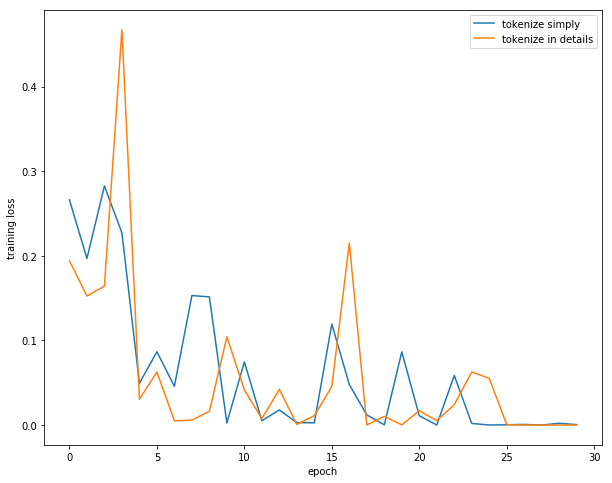

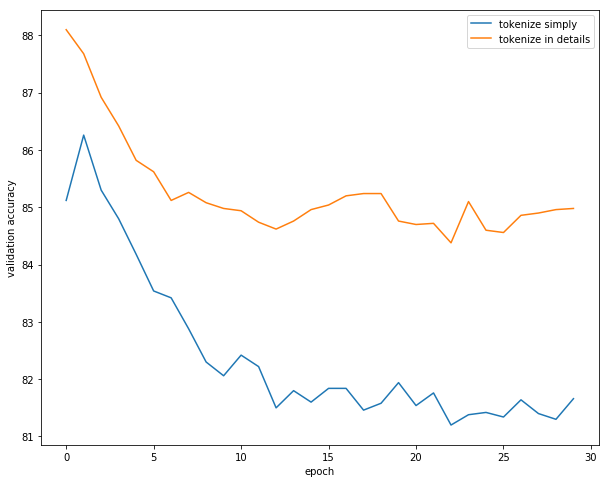

In [370]:
plt.figure()
plt.plot(train_loss_simple, label = 'tokenize simply')
plt.plot(train_loss_detailed, label = 'tokenize in details')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('training loss')


plt.figure()
plt.plot(val_acc_simple, label = 'tokenize simply')
plt.plot(val_acc_detailed, label = 'tokenize in details')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation accuracy')

In [416]:
print ("After training for 30 epochs")
results = [val_acc_simple[-1], val_acc_detailed[-1]]
max_val_acc = max(results)
max_val_acc_ind = results.index(max_val_acc)
print("The training losses are {}, {}".format(train_loss_simple[-1], train_loss_detailed[-1]))
print("The validation accuracy are {}, {}".format(val_acc_simple[-1], val_acc_detailed[-1]))

print ("The Maxmimum Val Acc is {} with {} tokenization".format(max_val_acc,
                                ['simple','detailed'][max_val_acc_ind]))

After training for 30 epochs
The training losses are 0.0004957094788551331, 4.859268665313721e-05
The validation accuracy are 81.66, 84.98
The Maxmimum Val Acc is 84.98 with detailed tokenization


# Optimization hyperparameters

### Adam optimizer

#### learning rate

In [372]:
learning_rates = [0.001, 0.01, 0.1]
train_loss_adam_lrs = []
val_acc_adam_lrs = []
for rate in learning_rates:
    train_loss_adam_lr, val_acc_adam_lr, _ = train_model(vocab_size = len(id2token), num_epochs = 30, 
                                                optim = 'Adam', learning_rate = rate)
    train_loss_adam_lrs.append(train_loss_adam_lr)
    val_acc_adam_lrs.append(val_acc_adam_lr)


Epoch: [1/30], Validation Acc: 80.34
Epoch: [2/30], Validation Acc: 85.94
Epoch: [3/30], Validation Acc: 87.28
Epoch: [4/30], Validation Acc: 87.76
Epoch: [5/30], Validation Acc: 88.2
Epoch: [6/30], Validation Acc: 88.48
Epoch: [7/30], Validation Acc: 88.2
Epoch: [8/30], Validation Acc: 88.38
Epoch: [9/30], Validation Acc: 87.96
Epoch: [10/30], Validation Acc: 88.12
Epoch: [11/30], Validation Acc: 87.92
Epoch: [12/30], Validation Acc: 87.84
Epoch: [13/30], Validation Acc: 87.54
Epoch: [14/30], Validation Acc: 87.48
Epoch: [15/30], Validation Acc: 87.52
Epoch: [16/30], Validation Acc: 87.42
Epoch: [17/30], Validation Acc: 87.2
Epoch: [18/30], Validation Acc: 87.1
Epoch: [19/30], Validation Acc: 87.08
Epoch: [20/30], Validation Acc: 86.96
Epoch: [21/30], Validation Acc: 86.86
Epoch: [22/30], Validation Acc: 86.58
Epoch: [23/30], Validation Acc: 86.56
Epoch: [24/30], Validation Acc: 86.56
Epoch: [25/30], Validation Acc: 86.3
Epoch: [26/30], Validation Acc: 86.06
Epoch: [27/30], Validation

#### annealing learning rate

In [380]:
train_loss_adam_lr, val_acc_adam_lr, _ = train_model(vocab_size = len(id2token), num_epochs = 30, 
                                                optim = 'Adam', learning_rate = 0.01, annealing_rate=0.1, step=15)


Epoch: [1/30], Validation Acc: 87.78
Epoch: [2/30], Validation Acc: 87.76
Epoch: [3/30], Validation Acc: 87.4
Epoch: [4/30], Validation Acc: 86.06
Epoch: [5/30], Validation Acc: 85.64
Epoch: [6/30], Validation Acc: 85.58
Epoch: [7/30], Validation Acc: 85.02
Epoch: [8/30], Validation Acc: 84.88
Epoch: [9/30], Validation Acc: 85.1
Epoch: [10/30], Validation Acc: 84.74
Epoch: [11/30], Validation Acc: 85.2
Epoch: [12/30], Validation Acc: 84.88
Epoch: [13/30], Validation Acc: 85.26
Epoch: [14/30], Validation Acc: 84.6
Epoch: [15/30], Validation Acc: 84.34
Epoch: [16/30], Validation Acc: 85.0
Epoch: [17/30], Validation Acc: 85.1
Epoch: [18/30], Validation Acc: 85.16
Epoch: [19/30], Validation Acc: 85.14
Epoch: [20/30], Validation Acc: 85.1
Epoch: [21/30], Validation Acc: 85.18
Epoch: [22/30], Validation Acc: 85.22
Epoch: [23/30], Validation Acc: 85.22
Epoch: [24/30], Validation Acc: 85.12
Epoch: [25/30], Validation Acc: 85.06
Epoch: [26/30], Validation Acc: 85.04
Epoch: [27/30], Validation A

Text(0.5,1,'Adam')

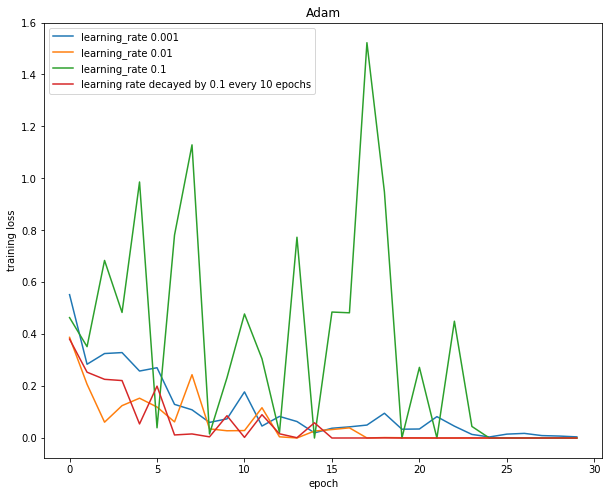

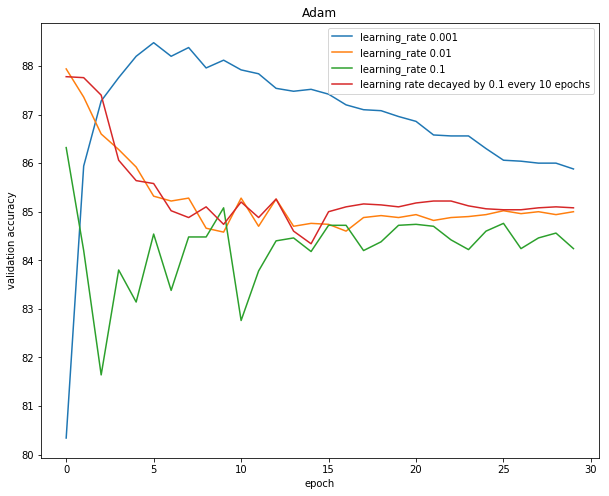

In [387]:
learning_rates = [0.001, 0.01, 0.1]
plt.figure()
for i in range(len(learning_rates)):
    plt.plot(range(30),train_loss_adam_lrs[i], label='learning_rate {:g}'.format(learning_rates[i]))
    
plt.plot(range(30), train_loss_adam_lr, label = 'learning rate decayed by 0.1 every 10 epochs')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.title('Adam')
    
plt.figure()
for i in range(len(learning_rates)):
    plt.plot(range(30),val_acc_adam_lrs[i], label='learning_rate {:g}'.format(learning_rates[i]))
plt.plot(range(30),val_acc_adam_lr, label = 'learning rate decayed by 0.1 every 10 epochs')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Adam')

### SGD optimizer

#### learning rate

In [407]:
learning_rates = [0.05, 0.1, 0.5]
train_loss_sgd_lrs = []
val_acc_sgd_lrs = []
for rate in learning_rates:
    train_loss_sgd_lr, val_acc_sgd_lr, _ = train_model(vocab_size = len(id2token), num_epochs = 200, 
                                                optim = 'SGD', learning_rate = rate)
    train_loss_sgd_lrs.append(train_loss_sgd_lr)
    val_acc_sgd_lrs.append(val_acc_sgd_lr)


Epoch: [1/200], Validation Acc: 61.56
Epoch: [2/200], Validation Acc: 63.88
Epoch: [3/200], Validation Acc: 64.88
Epoch: [4/200], Validation Acc: 65.42
Epoch: [5/200], Validation Acc: 65.58
Epoch: [6/200], Validation Acc: 66.32
Epoch: [7/200], Validation Acc: 66.62
Epoch: [8/200], Validation Acc: 67.28
Epoch: [9/200], Validation Acc: 67.7
Epoch: [10/200], Validation Acc: 68.02
Epoch: [11/200], Validation Acc: 68.58
Epoch: [12/200], Validation Acc: 68.98
Epoch: [13/200], Validation Acc: 69.56
Epoch: [14/200], Validation Acc: 69.92
Epoch: [15/200], Validation Acc: 70.12
Epoch: [16/200], Validation Acc: 70.2
Epoch: [17/200], Validation Acc: 70.7
Epoch: [18/200], Validation Acc: 70.96
Epoch: [19/200], Validation Acc: 71.28
Epoch: [20/200], Validation Acc: 71.56
Epoch: [21/200], Validation Acc: 71.78
Epoch: [22/200], Validation Acc: 72.14
Epoch: [23/200], Validation Acc: 72.4
Epoch: [24/200], Validation Acc: 72.6
Epoch: [25/200], Validation Acc: 72.86
Epoch: [26/200], Validation Acc: 73.02


Epoch: [10/200], Validation Acc: 71.04
Epoch: [11/200], Validation Acc: 71.42
Epoch: [12/200], Validation Acc: 72.02
Epoch: [13/200], Validation Acc: 72.4
Epoch: [14/200], Validation Acc: 73.06
Epoch: [15/200], Validation Acc: 73.68
Epoch: [16/200], Validation Acc: 73.8
Epoch: [17/200], Validation Acc: 73.94
Epoch: [18/200], Validation Acc: 74.28
Epoch: [19/200], Validation Acc: 74.66
Epoch: [20/200], Validation Acc: 75.3
Epoch: [21/200], Validation Acc: 75.38
Epoch: [22/200], Validation Acc: 75.66
Epoch: [23/200], Validation Acc: 75.98
Epoch: [24/200], Validation Acc: 75.96
Epoch: [25/200], Validation Acc: 76.3
Epoch: [26/200], Validation Acc: 76.2
Epoch: [27/200], Validation Acc: 76.78
Epoch: [28/200], Validation Acc: 77.06
Epoch: [29/200], Validation Acc: 77.0
Epoch: [30/200], Validation Acc: 77.4
Epoch: [31/200], Validation Acc: 77.58
Epoch: [32/200], Validation Acc: 77.68
Epoch: [33/200], Validation Acc: 78.08
Epoch: [34/200], Validation Acc: 77.98
Epoch: [35/200], Validation Acc:

Epoch: [19/200], Validation Acc: 83.06
Epoch: [20/200], Validation Acc: 83.18
Epoch: [21/200], Validation Acc: 83.36
Epoch: [22/200], Validation Acc: 83.46
Epoch: [23/200], Validation Acc: 83.5
Epoch: [24/200], Validation Acc: 83.5
Epoch: [25/200], Validation Acc: 83.54
Epoch: [26/200], Validation Acc: 83.6
Epoch: [27/200], Validation Acc: 84.04
Epoch: [28/200], Validation Acc: 83.62
Epoch: [29/200], Validation Acc: 84.1
Epoch: [30/200], Validation Acc: 83.94
Epoch: [31/200], Validation Acc: 84.38
Epoch: [32/200], Validation Acc: 84.36
Epoch: [33/200], Validation Acc: 84.16
Epoch: [34/200], Validation Acc: 84.38
Epoch: [35/200], Validation Acc: 84.24
Epoch: [36/200], Validation Acc: 84.3
Epoch: [37/200], Validation Acc: 84.4
Epoch: [38/200], Validation Acc: 84.46
Epoch: [39/200], Validation Acc: 84.64
Epoch: [40/200], Validation Acc: 84.78
Epoch: [41/200], Validation Acc: 84.7
Epoch: [42/200], Validation Acc: 84.64
Epoch: [43/200], Validation Acc: 84.8
Epoch: [44/200], Validation Acc: 

#### annealing learning rate

In [411]:
train_loss_sgd_lr, val_acc_sgd_lr, _ = train_model(vocab_size = len(id2token), num_epochs = 100, 
                                                optim = 'SGD', learning_rate = 0.5, annealing_rate=0.2, step=25)


Epoch: [1/100], Validation Acc: 70.24
Epoch: [2/100], Validation Acc: 72.04
Epoch: [3/100], Validation Acc: 74.22
Epoch: [4/100], Validation Acc: 76.06
Epoch: [5/100], Validation Acc: 77.08
Epoch: [6/100], Validation Acc: 78.12
Epoch: [7/100], Validation Acc: 78.98
Epoch: [8/100], Validation Acc: 79.76
Epoch: [9/100], Validation Acc: 80.12
Epoch: [10/100], Validation Acc: 80.5
Epoch: [11/100], Validation Acc: 80.92
Epoch: [12/100], Validation Acc: 81.34
Epoch: [13/100], Validation Acc: 81.96
Epoch: [14/100], Validation Acc: 82.42
Epoch: [15/100], Validation Acc: 82.44
Epoch: [16/100], Validation Acc: 82.8
Epoch: [17/100], Validation Acc: 82.86
Epoch: [18/100], Validation Acc: 83.22
Epoch: [19/100], Validation Acc: 83.48
Epoch: [20/100], Validation Acc: 83.7
Epoch: [21/100], Validation Acc: 83.82
Epoch: [22/100], Validation Acc: 83.64
Epoch: [23/100], Validation Acc: 83.78
Epoch: [24/100], Validation Acc: 84.1
Epoch: [25/100], Validation Acc: 83.92
Epoch: [26/100], Validation Acc: 84.1


Text(0.5,1,'SGD')

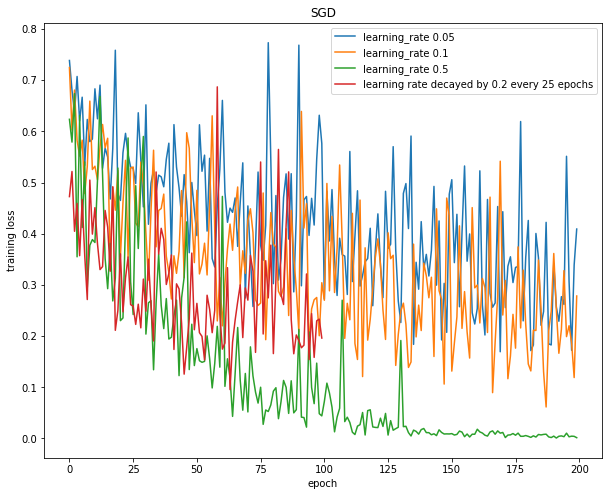

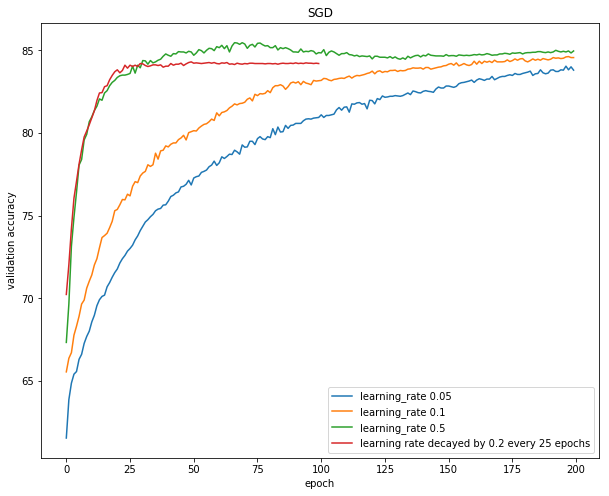

In [412]:
learning_rates = [0.05, 0.1, 0.5]

plt.figure()
for i in range(len(learning_rates)):
    plt.plot(range(200),train_loss_sgd_lrs[i], label='learning_rate {:g}'.format(learning_rates[i]))
    
plt.plot(range(100),train_loss_sgd_lr, label = 'learning rate decayed by 0.2 every 25 epochs')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.title('SGD')


plt.figure()
for i in range(len(learning_rates)):
    plt.plot(range(200),val_acc_sgd_lrs[i], label='learning_rate {:g}'.format(learning_rates[i]))

plt.plot(range(100),val_acc_sgd_lr, label = 'learning rate decayed by 0.2 every 25 epochs')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('SGD')

# Model hyperparameters

### embedding size

In [401]:
emb_dims = [50, 100, 200, 400]
train_loss_embs = []
val_acc_embs = []
for emb_dim in emb_dims:
    train_loss_emb, val_acc_emb, _ = train_model(emb_dim = emb_dim, num_epochs = 30, vocab_size = len(id2token))
    train_loss_embs.append(train_loss_emb)
    val_acc_embs.append(val_acc_emb)
    

Epoch: [1/30], Validation Acc: 87.96
Epoch: [2/30], Validation Acc: 87.92
Epoch: [3/30], Validation Acc: 87.16
Epoch: [4/30], Validation Acc: 86.34
Epoch: [5/30], Validation Acc: 86.1
Epoch: [6/30], Validation Acc: 85.74
Epoch: [7/30], Validation Acc: 85.48
Epoch: [8/30], Validation Acc: 85.56
Epoch: [9/30], Validation Acc: 85.34
Epoch: [10/30], Validation Acc: 85.44
Epoch: [11/30], Validation Acc: 84.96
Epoch: [12/30], Validation Acc: 85.44
Epoch: [13/30], Validation Acc: 85.18
Epoch: [14/30], Validation Acc: 85.04
Epoch: [15/30], Validation Acc: 84.92
Epoch: [16/30], Validation Acc: 85.04
Epoch: [17/30], Validation Acc: 85.16
Epoch: [18/30], Validation Acc: 85.06
Epoch: [19/30], Validation Acc: 85.06
Epoch: [20/30], Validation Acc: 85.02
Epoch: [21/30], Validation Acc: 85.12
Epoch: [22/30], Validation Acc: 85.08
Epoch: [23/30], Validation Acc: 85.22
Epoch: [24/30], Validation Acc: 85.2
Epoch: [25/30], Validation Acc: 85.2
Epoch: [26/30], Validation Acc: 85.2
Epoch: [27/30], Validatio

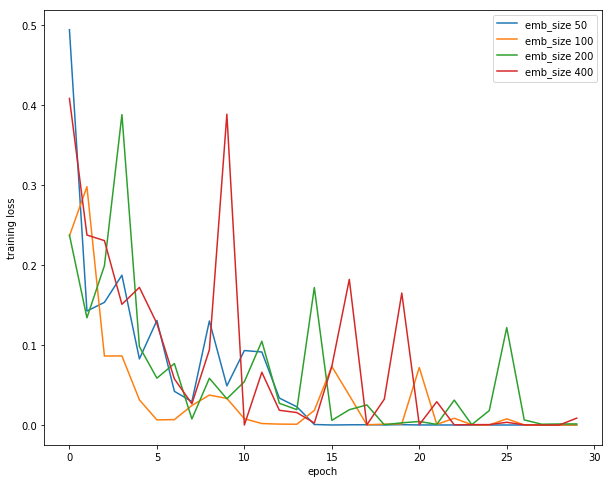

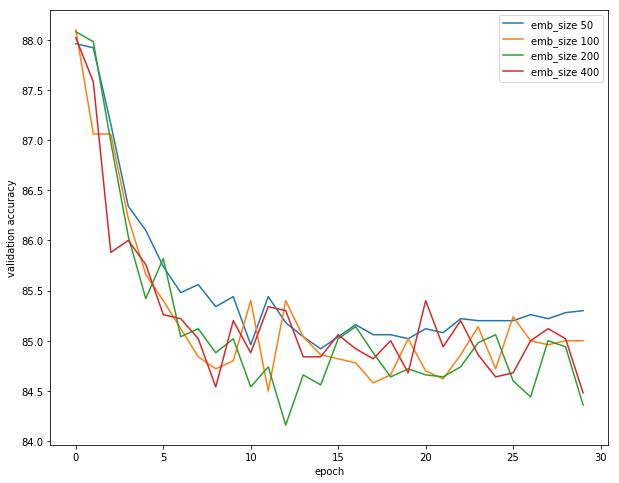

In [402]:
plt.figure()
for i in range(len(train_loss_embs)):
    plt.plot(range(30),train_loss_embs[i], label='emb_size %d' %emb_dims[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('training loss')


plt.figure()
for i in range(len(val_acc_embs)):
    plt.plot(range(30),val_acc_embs[i], label='emb_size %d' %emb_dims[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')

In [421]:
print ("After training for 30 epochs")
results = [element[-1] for element in val_acc_embs]
max_val_acc = max(results)
max_val_acc_ind = results.index(max_val_acc)
print("The training losses are {}, {}, {}, {}".format(train_loss_embs[0][-1], 
                            train_loss_embs[1][-1], train_loss_embs[2][-1], train_loss_embs[3][-1]))
print("The validation accuracy are {}, {}, {}, {}".format(val_acc_embs[0][-1], 
                            val_acc_embs[1][-1], val_acc_embs[2][-1], val_acc_embs[3][-1]))
      
print ("The Maxmimum Val Acc is {} with Embedding Size {}".format(max_val_acc, emb_dims[max_val_acc_ind]))

After training for 30 epochs
The training losses are 8.344650268554688e-06, 4.9173831939697266e-06, 0.0013913214206695557, 0.008597426116466522
The validation accuracy are 85.3, 85.0, 84.36, 84.48
The Maxmimum Val Acc is 85.3 with Embedding Size 50


### vocabulary size

In [623]:
max_vocab_sizes = [10000, 50000, 100000, 200000]
train_loss_vocabs = []
val_acc_vocabs = []
for size in max_vocab_sizes:
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = size)
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    test_data_indices = token2index_dataset(test_data_tokens)
    # create pytorch dataloader
    #train_loader = NewsGroupDataset(train_data_indices, train_targets)
    #val_loader = NewsGroupDataset(val_data_indices, val_targets)
    #test_loader = NewsGroupDataset(test_data_indices, test_targets)

    BATCH_SIZE = 32
    train_dataset = NewsGroupDataset(train_data_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True) 
    # no need for test data right now

#     test_dataset = NewsGroupDataset(test_data_indices, test_targets)
#     test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                                batch_size=BATCH_SIZE,
#                                                collate_fn=newsgroup_collate_func,
#                                                shuffle=False)

    train_loss_vocab, val_acc_vocab, _ = train_model(vocab_size = len(id2token),num_epochs = 30)
    train_loss_vocabs.append(train_loss_vocab)
    val_acc_vocabs.append(val_acc_vocab)

Epoch: [1/30], Validation Acc: 87.76
Epoch: [2/30], Validation Acc: 87.4
Epoch: [3/30], Validation Acc: 86.86
Epoch: [4/30], Validation Acc: 86.2
Epoch: [5/30], Validation Acc: 85.64
Epoch: [6/30], Validation Acc: 85.16
Epoch: [7/30], Validation Acc: 85.46
Epoch: [8/30], Validation Acc: 85.2
Epoch: [9/30], Validation Acc: 84.84
Epoch: [10/30], Validation Acc: 84.72
Epoch: [11/30], Validation Acc: 85.2
Epoch: [12/30], Validation Acc: 84.58
Epoch: [13/30], Validation Acc: 84.24
Epoch: [14/30], Validation Acc: 84.36
Epoch: [15/30], Validation Acc: 84.6
Epoch: [16/30], Validation Acc: 84.62
Epoch: [17/30], Validation Acc: 84.64
Epoch: [18/30], Validation Acc: 84.54
Epoch: [19/30], Validation Acc: 84.48
Epoch: [20/30], Validation Acc: 84.3
Epoch: [21/30], Validation Acc: 84.52
Epoch: [22/30], Validation Acc: 84.26
Epoch: [23/30], Validation Acc: 84.4
Epoch: [24/30], Validation Acc: 84.44
Epoch: [25/30], Validation Acc: 84.16
Epoch: [26/30], Validation Acc: 84.5
Epoch: [27/30], Validation Ac

Text(0,0.5,'validation accuracy')

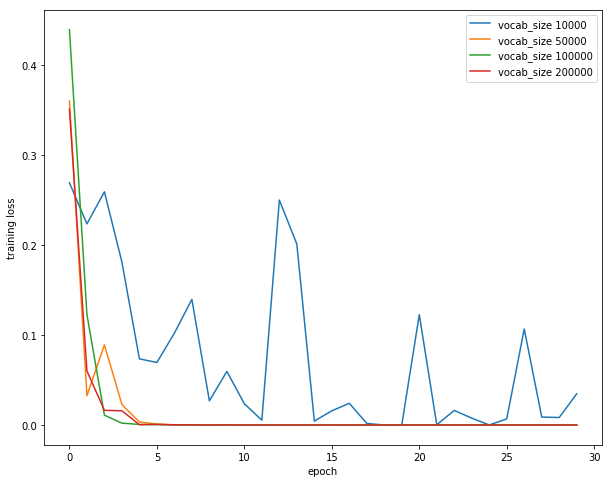

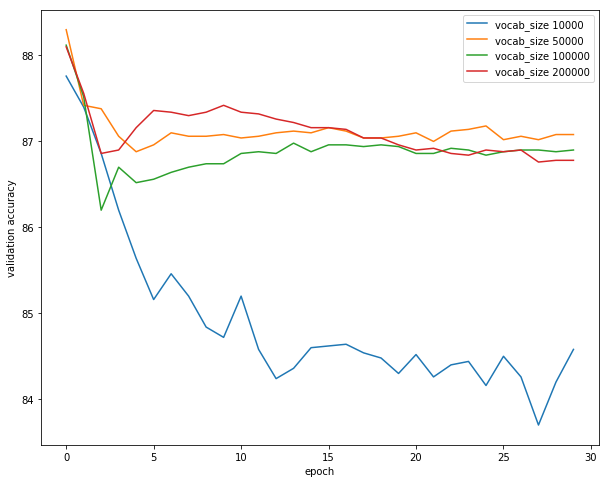

In [624]:
plt.figure()
for i in range(len(train_loss_vocabs)):
    plt.plot(range(30),train_loss_vocabs[i], label='vocab_size %d' %max_vocab_sizes[i])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('training loss')


plt.figure()
for i in range(len(val_acc_vocabs)):
    plt.plot(range(30),val_acc_vocabs[i], label='vocab_size %d' %max_vocab_sizes[i])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation accuracy')

In [625]:
print ("After training for 30 epochs")
results = [element[-1] for element in val_acc_vocabs]
max_val_acc = max(results)
max_val_acc_ind = results.index(max_val_acc)
print("The training losses are {}, {}, {}, {}".format(train_loss_vocabs[0][-1], train_loss_vocabs[1][-1],
                                            train_loss_vocabs[2][-1], train_loss_vocabs[3][-1]))
print("The validation accuracy are {}, {}, {}, {}".format(val_acc_vocabs[0][-1], val_acc_vocabs[1][-1],
                                            val_acc_vocabs[2][-1], val_acc_vocabs[3][-1]))
print ("The Maxmimum Val Acc is {} with Vocab Size {}".format(max_val_acc, max_vocab_sizes[max_val_acc_ind]))

After training for 30 epochs
The training losses are 0.03476259112358093, 2.9802322387695312e-08, 5.960464477539063e-08, 1.1920928955078125e-07
The validation accuracy are 84.58, 87.08, 86.9, 86.78
The Maxmimum Val Acc is 87.08 with Vocab Size 50000


### N-gram

In [388]:
# # val set tokens
# print ("Tokenizing val data")
# bi_val_data_tokens, _ = tokenize_dataset(val_data, n_gram=2, tokenize_scheme = 'detailed')
# pkl.dump(bi_val_data_tokens, open("bi_val_data_tokens_detailed.p", "wb"))

# # test set tokens
# print ("Tokenizing test data")
# bi_test_data_tokens, _ = tokenize_dataset(test_data, n_gram=2, tokenize_scheme = 'detailed')
# pkl.dump(bi_test_data_tokens, open("bi_test_data_tokens_detailed.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# bi_train_data_tokens, bi_all_train_tokens = tokenize_dataset(train_data, n_gram=2, tokenize_scheme = 'detailed')
# pkl.dump(bi_train_data_tokens, open("bi_train_data_tokens_detailed.p", "wb"))
# pkl.dump(bi_all_train_tokens, open("bi_all_train_tokens_detailed.p", "wb"))


# # val set tokens
# print ("Tokenizing val data")
# tri_val_data_tokens, _ = tokenize_dataset(val_data, n_gram=3, tokenize_scheme = 'detailed')
# pkl.dump(tri_val_data_tokens, open("tri_val_data_tokens_detailed.p", "wb"))

# # test set tokens
# print ("Tokenizing test data")
# tri_test_data_tokens, _ = tokenize_dataset(test_data, n_gram=3, tokenize_scheme = 'detailed')
# pkl.dump(tri_test_data_tokens, open("tri_test_data_tokens_detailed.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# tri_train_data_tokens, tri_all_train_tokens = tokenize_dataset(train_data, n_gram=3, tokenize_scheme = 'detailed')
# pkl.dump(tri_train_data_tokens, open("tri_train_data_tokens_detailed.p", "wb"))
# pkl.dump(tri_all_train_tokens, open("tri_all_train_tokens_detailed.p", "wb"))

# # val set tokens
# print ("Tokenizing val data")
# four_val_data_tokens, _ = tokenize_dataset(val_data, n_gram=4, tokenize_scheme = 'detailed')
# pkl.dump(four_val_data_tokens, open("four_val_data_tokens_detailed.p", "wb"))

# # test set tokens
# print ("Tokenizing test data")
# four_test_data_tokens, _ = tokenize_dataset(test_data, n_gram=4, tokenize_scheme = 'detailed')
# pkl.dump(four_test_data_tokens, open("four_test_data_tokens_detailed.p", "wb"))

# # train set tokens
# print ("Tokenizing train data")
# four_train_data_tokens, four_all_train_tokens = tokenize_dataset(train_data, n_gram=4, tokenize_scheme = 'detailed')
# pkl.dump(four_train_data_tokens, open("four_train_data_tokens_detailed.p", "wb"))
# pkl.dump(four_all_train_tokens, open("four_all_train_tokens_detailed.p", "wb"))



Tokenizing val data
Tokenizing test data
Tokenizing train data
Tokenizing val data
Tokenizing test data
Tokenizing train data
Tokenizing val data
Tokenizing test data
Tokenizing train data


In [389]:
# Then, load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens_detailed.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_detailed.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_detailed.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_detailed.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)
# no need for test data right now

# test_dataset = NewsGroupDataset(test_data_indices, test_targets)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=newsgroup_collate_func,
#                                            shuffle=False)  
        


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 2174614


In [390]:
train_loss_word, val_acc_word, _ = train_model(vocab_size = len(id2token), num_epochs = 30)

Epoch: [1/30], Validation Acc: 87.44
Epoch: [2/30], Validation Acc: 86.76
Epoch: [3/30], Validation Acc: 86.7
Epoch: [4/30], Validation Acc: 86.46
Epoch: [5/30], Validation Acc: 85.36
Epoch: [6/30], Validation Acc: 85.54
Epoch: [7/30], Validation Acc: 85.46
Epoch: [8/30], Validation Acc: 84.84
Epoch: [9/30], Validation Acc: 84.42
Epoch: [10/30], Validation Acc: 84.86
Epoch: [11/30], Validation Acc: 84.18
Epoch: [12/30], Validation Acc: 84.86
Epoch: [13/30], Validation Acc: 84.76
Epoch: [14/30], Validation Acc: 84.84
Epoch: [15/30], Validation Acc: 84.66
Epoch: [16/30], Validation Acc: 84.74
Epoch: [17/30], Validation Acc: 84.68
Epoch: [18/30], Validation Acc: 84.9
Epoch: [19/30], Validation Acc: 85.06
Epoch: [20/30], Validation Acc: 84.62
Epoch: [21/30], Validation Acc: 85.12
Epoch: [22/30], Validation Acc: 84.54
Epoch: [23/30], Validation Acc: 84.34
Epoch: [24/30], Validation Acc: 84.64
Epoch: [25/30], Validation Acc: 83.88
Epoch: [26/30], Validation Acc: 84.2
Epoch: [27/30], Validati

In [391]:
# Then, load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("bi_train_data_tokens_detailed.p", "rb"))
all_train_tokens = pkl.load(open("bi_all_train_tokens_detailed.p", "rb"))

val_data_tokens = pkl.load(open("bi_val_data_tokens_detailed.p", "rb"))
test_data_tokens = pkl.load(open("bi_test_data_tokens_detailed.p", "rb"))


token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)
# no need for test data right now

# test_dataset = NewsGroupDataset(test_data_indices, test_targets)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=newsgroup_collate_func,
#                                            shuffle=False)  
        


In [392]:
train_loss_bigram, val_acc_bigram, _ = train_model(num_epochs = 30, vocab_size = len(id2token))

Epoch: [1/30], Validation Acc: 80.12
Epoch: [2/30], Validation Acc: 79.16
Epoch: [3/30], Validation Acc: 78.52
Epoch: [4/30], Validation Acc: 78.42
Epoch: [5/30], Validation Acc: 77.06
Epoch: [6/30], Validation Acc: 77.24
Epoch: [7/30], Validation Acc: 76.5
Epoch: [8/30], Validation Acc: 76.1
Epoch: [9/30], Validation Acc: 76.1
Epoch: [10/30], Validation Acc: 76.1
Epoch: [11/30], Validation Acc: 76.26
Epoch: [12/30], Validation Acc: 75.9
Epoch: [13/30], Validation Acc: 75.42
Epoch: [14/30], Validation Acc: 75.34
Epoch: [15/30], Validation Acc: 75.22
Epoch: [16/30], Validation Acc: 75.34
Epoch: [17/30], Validation Acc: 75.06
Epoch: [18/30], Validation Acc: 74.98
Epoch: [19/30], Validation Acc: 75.12
Epoch: [20/30], Validation Acc: 74.62
Epoch: [21/30], Validation Acc: 74.88
Epoch: [22/30], Validation Acc: 74.62
Epoch: [23/30], Validation Acc: 74.44
Epoch: [24/30], Validation Acc: 74.58
Epoch: [25/30], Validation Acc: 74.62
Epoch: [26/30], Validation Acc: 74.72
Epoch: [27/30], Validation

In [393]:
train_data_tokens = pkl.load(open("tri_train_data_tokens_detailed.p", "rb"))
all_train_tokens = pkl.load(open("tri_all_train_tokens_detailed.p", "rb"))

val_data_tokens = pkl.load(open("tri_val_data_tokens_detailed.p", "rb"))
test_data_tokens = pkl.load(open("tri_test_data_tokens_detailed.p", "rb"))

token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)
# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)
# no need for test data right now

# test_dataset = NewsGroupDataset(test_data_indices, test_targets)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=newsgroup_collate_func,
#                                            shuffle=False)  
        


In [394]:
train_loss_trigram, val_acc_trigram, _ = train_model(num_epochs = 30, vocab_size = len(id2token))

Epoch: [1/30], Validation Acc: 58.4
Epoch: [2/30], Validation Acc: 61.92
Epoch: [3/30], Validation Acc: 62.12
Epoch: [4/30], Validation Acc: 62.32
Epoch: [5/30], Validation Acc: 62.74
Epoch: [6/30], Validation Acc: 62.86
Epoch: [7/30], Validation Acc: 62.2
Epoch: [8/30], Validation Acc: 60.74
Epoch: [9/30], Validation Acc: 62.32
Epoch: [10/30], Validation Acc: 61.36
Epoch: [11/30], Validation Acc: 62.28
Epoch: [12/30], Validation Acc: 61.58
Epoch: [13/30], Validation Acc: 61.9
Epoch: [14/30], Validation Acc: 61.88
Epoch: [15/30], Validation Acc: 62.4
Epoch: [16/30], Validation Acc: 62.34
Epoch: [17/30], Validation Acc: 62.48
Epoch: [18/30], Validation Acc: 61.68
Epoch: [19/30], Validation Acc: 61.26
Epoch: [20/30], Validation Acc: 61.56
Epoch: [21/30], Validation Acc: 61.04
Epoch: [22/30], Validation Acc: 62.58
Epoch: [23/30], Validation Acc: 62.42
Epoch: [24/30], Validation Acc: 61.28
Epoch: [25/30], Validation Acc: 61.88
Epoch: [26/30], Validation Acc: 62.46
Epoch: [27/30], Validatio

In [395]:
train_data_tokens = pkl.load(open("four_train_data_tokens_detailed.p", "rb"))
all_train_tokens = pkl.load(open("four_all_train_tokens_detailed.p", "rb"))

val_data_tokens = pkl.load(open("four_val_data_tokens_detailed.p", "rb"))
test_data_tokens = pkl.load(open("four_test_data_tokens_detailed.p", "rb"))

token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)
# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)
# no need for test data right now

# test_dataset = NewsGroupDataset(test_data_indices, test_targets)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=newsgroup_collate_func,
#                                            shuffle=False)  
        


In [396]:
train_loss_fourgram, val_acc_fourgram, _ = train_model(num_epochs = 30, vocab_size = len(id2token))

Epoch: [1/30], Validation Acc: 49.32
Epoch: [2/30], Validation Acc: 53.26
Epoch: [3/30], Validation Acc: 52.06
Epoch: [4/30], Validation Acc: 52.64
Epoch: [5/30], Validation Acc: 54.18
Epoch: [6/30], Validation Acc: 52.44
Epoch: [7/30], Validation Acc: 54.12
Epoch: [8/30], Validation Acc: 54.1
Epoch: [9/30], Validation Acc: 52.6
Epoch: [10/30], Validation Acc: 54.14
Epoch: [11/30], Validation Acc: 52.52
Epoch: [12/30], Validation Acc: 54.08
Epoch: [13/30], Validation Acc: 52.4
Epoch: [14/30], Validation Acc: 52.2
Epoch: [15/30], Validation Acc: 54.1
Epoch: [16/30], Validation Acc: 52.34
Epoch: [17/30], Validation Acc: 52.44
Epoch: [18/30], Validation Acc: 52.44
Epoch: [19/30], Validation Acc: 53.96
Epoch: [20/30], Validation Acc: 53.98
Epoch: [21/30], Validation Acc: 52.44
Epoch: [22/30], Validation Acc: 53.96
Epoch: [23/30], Validation Acc: 52.48
Epoch: [24/30], Validation Acc: 52.3
Epoch: [25/30], Validation Acc: 54.0
Epoch: [26/30], Validation Acc: 53.96
Epoch: [27/30], Validation A

Text(0,0.5,'validation accuracy')

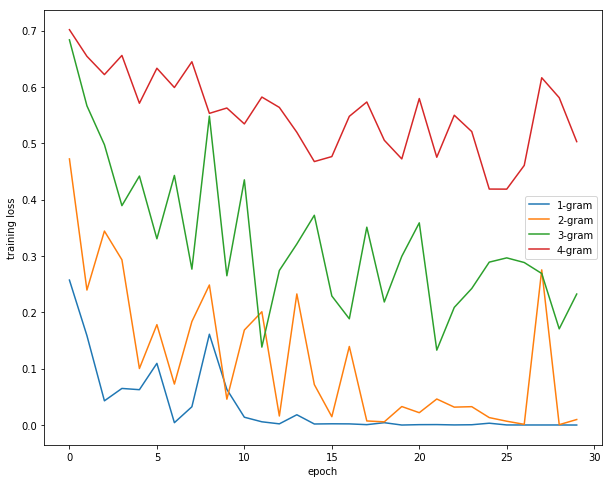

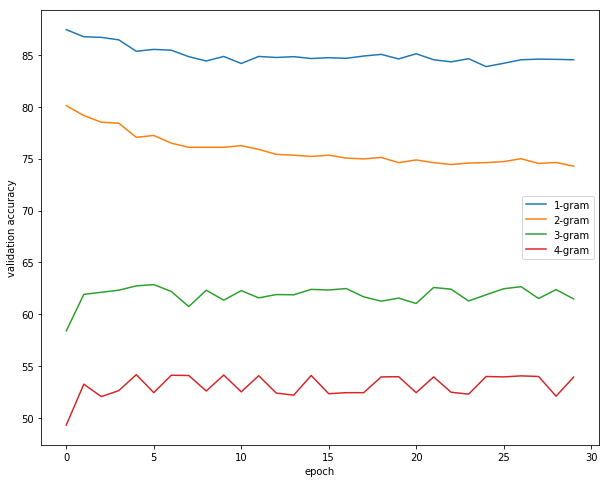

In [397]:
plt.figure()
plt.plot(train_loss_word, label = '1-gram')
plt.plot(train_loss_bigram, label = '2-gram')
plt.plot(train_loss_trigram, label = '3-gram')
plt.plot(train_loss_fourgram, label = '4-gram')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('training loss')


plt.figure()
plt.plot(val_acc_word, label = '1-gram')
plt.plot(val_acc_bigram, label = '2-gram')
plt.plot(val_acc_trigram, label = '3-gram')
plt.plot(val_acc_fourgram, label = '4-gram')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation accuracy')

In [430]:
print ("After training for 30 epochs")
results = [val_acc_word[-1], val_acc_bigram[-1], val_acc_trigram[-1], val_acc_fourgram[-1]]
max_val_acc = max(results)
max_val_acc_ind = results.index(max_val_acc)
print("The training losses are {}, {}, {}, {}".format(train_loss_word[-1], train_loss_bigram[-1],
                                            train_loss_trigram[-1], train_loss_fourgram[-1]))
print("The validation accuracy are {}, {}, {}, {}".format(val_acc_word[-1], val_acc_bigram[-1],
                                            val_acc_trigram[-1], val_acc_fourgram[-1]))
print ("The Maxmimum Val Acc is {} with {}-gram".format(max_val_acc, max_val_acc_ind+1))

After training for 30 epochs
The training losses are 2.0563602447509766e-05, 0.009786441922187805, 0.23246371746063232, 0.502927303314209
The validation accuracy are 84.54, 74.28, 61.48, 53.94
The Maxmimum Val Acc is 84.54 with 1-gram


# Train best model and report results

In [499]:
# Then, load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens_detailed.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_detailed.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_detailed.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_detailed.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

token2id, id2token = build_vocab(all_train_tokens, max_vocab_size = 100000)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)  
        


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 2174614


In [436]:
train_loss, val_acc, model = train_model(emb_dim=50, vocab_size = len(id2token), learning_rate = 0.01,
                                  num_epochs = 30, optim = 'Adam')


Epoch: [1/30], Validation Acc: 88.46
Epoch: [2/30], Validation Acc: 87.8
Epoch: [3/30], Validation Acc: 87.12
Epoch: [4/30], Validation Acc: 86.7
Epoch: [5/30], Validation Acc: 86.92
Epoch: [6/30], Validation Acc: 86.96
Epoch: [7/30], Validation Acc: 87.1
Epoch: [8/30], Validation Acc: 87.08
Epoch: [9/30], Validation Acc: 87.14
Epoch: [10/30], Validation Acc: 86.92
Epoch: [11/30], Validation Acc: 86.9
Epoch: [12/30], Validation Acc: 87.0
Epoch: [13/30], Validation Acc: 87.06
Epoch: [14/30], Validation Acc: 87.06
Epoch: [15/30], Validation Acc: 86.96
Epoch: [16/30], Validation Acc: 87.0
Epoch: [17/30], Validation Acc: 86.92
Epoch: [18/30], Validation Acc: 86.94
Epoch: [19/30], Validation Acc: 86.9
Epoch: [20/30], Validation Acc: 86.9
Epoch: [21/30], Validation Acc: 86.96
Epoch: [22/30], Validation Acc: 86.94
Epoch: [23/30], Validation Acc: 86.84
Epoch: [24/30], Validation Acc: 86.84
Epoch: [25/30], Validation Acc: 86.86
Epoch: [26/30], Validation Acc: 86.82
Epoch: [27/30], Validation Ac

In [626]:
print("After 30 epochs")
print("The validation accuracy is {}".format(val_acc[-1]))
print ("Test Acc {}".format(test_model(test_loader, model)))

After 30 epochs
The validation accuracy is 86.9
Test Acc 83.192


In [582]:
def find_example_index():
    wrong_indices = []
    correct_indices = []
    n_loop = 0
    for data, lengths, labels in val_loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        wrong = predicted.eq(labels.view_as(predicted))==0
        correct = predicted.eq(labels.view_as(predicted))==1
        wrong_indices_current = np.where(np.array(wrong).ravel())[0].tolist()
        correct_indices_current = np.where(np.array(correct).ravel())[0].tolist()
        wrong_indices.extend([index + 32*n_loop for index in wrong_indices_current])
        correct_indices.extend([index + 32*n_loop for index in correct_indices_current])
        n_loop += 1
    return wrong_indices, correct_indices
        


In [583]:
wrong_indices, correct_indices = find_example_index()

In [617]:
import random
print("Three incorrect examples\n")
for index in random.sample(wrong_indices,3):
    print("Movie review: {}. \n It is originally labeled as:{}, we predict it as:{}".format(val_data[index],
          val_targets[index], abs(val_targets[index]-1)))
    print('\n')


Three incorrect examples

Movie review: The romance of the movie, which is also its main theme, is good and nicely presented. However, the surrounding of the love story is too lyric, graphical and unrealistic. Even worse, the psychology of the main character is weird and incomprehensible, exactly like the end of the movie. Don't hesitate to watch this movie, if it attracted your interest, but don't expect too much of it either.. 
 It is originally labeled as:1, we predict it as:0


Movie review: If you liked watching Mel Gibson in Million Dollar Hotel then you might enjoy watching Burt Reynolds in yet another film so bad it could never be distributed. I can only attest to the DVD version so maybe the VHS version is better quality wise but the movies night and dark scenes have been so poorly done that everythings seems red. I first thought my DVD players was messed up. It wasn't. If you insist on watching it I recommend you adjust the color on your TV until it is black and white. If you

In [622]:
print("Three correct examples\n")
for index in random.sample(correct_index,3):
    print(val_data[index])
    print('\n')


Three correct examples

Revolutions always present opportunities for dramatic films since, in fact, most revolutions are in themselves dramatic events. Unfortunately, what this film lacks in drama is compensated for by an overabundance of boredom. One cares not who wins, loses, dies or lives--just end it as soon as possible. This is due in large measure to what seems to me to be a superficial use of background technology. Scenes of Paris and the French countryside have a cardboard quality about them. They might better be done on a bare stage and left that way. One cannot expect the amazing effects of "The House of the Flying Daggers" or "The Golden Compass," but , after all, this is a 2002 digitally mastered production. Characters seem to enter a scene for the sake of entering a scene, so much so that one loses count of the number of times character enter and leave rooms. In my view, this film turns the French Revolution of the 1790s into the "papier-mache" revolution of a "papier coll